In [2]:
import json
import math
from typing import Literal

from atproto_client.models.app.bsky.actor.defs import ProfileView, ProfileViewDetailed
from atproto_client.models.app.bsky.feed.defs import ThreadViewPost
from atproto_client.models.app.bsky.feed.post import GetRecordResponse
from atproto_client.models.app.bsky.feed.get_likes import Like
from atproto_client.models.app.bsky.feed.get_post_thread import Response as PostThreadResponse

import pandas as pd
import matplotlib.pyplot as plt

from lib.helper import client
from services.classify.models.perspective_api import perform_batch_inference
from services.sync.search.helper import send_request_with_pagination

file_cache is only supported with oauth2client<4.0.0


In [202]:
pd.set_option("max_colwidth", None)

In [16]:
civic_posts = pd.read_csv('sample_bluesky_civic_posts.csv')
noncivic_posts = pd.read_csv('sample_bluesky_noncivic_posts.csv')

Let's grab the most up-to-date engagement data for each post. We have the link for each post so we can easily get the post ID. Let's grab the post record object given the link for the post.

### Step 1: Grab post information given the link to a post

In [3]:
def get_author_handle_and_post_id_from_link(link: str) -> dict[str, str]:
    """Given a link, get the author and post ID.
    
    Example:
    >get_author_and_post_id_from_link("https://bsky.app/profile/scottsantens.com/post/3knqkh2es7k2i")
    {'author': 'scottsantens.com', 'post_id': '3knqkh2es7k2i}
    """
    # Split the link by the forward slash
    split_link = link.split("/")
    # Get the author and post ID
    author = split_link[4]
    post_id = split_link[6]
    return {"author": author, "post_id": post_id}

In [4]:
def get_author_did_from_handle(author_handle: str) -> str:
    """Given an author handle, get the DID.
    
    Example:
    >get_author_did_from_handle("scottsantens.com")
    "did:example:123"
    """
    # Get the profile
    profile = client.get_profile(author_handle)
    # Get the DID
    return profile["did"]


In [5]:
def get_post_record_from_post_link(link: str) -> GetRecordResponse:
    """Given a post link, get the post record.
    
    Example:
    >post = get_post_record_from_post_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24")
    GetRecordResponse(
        uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
        value=Record(created_at='2024-03-16T12:17:36.784Z', text='A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women in the club was enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often', embed=Main(record=Main(cid='bafyreiesskdi2vfkrvj2kaajglsklqd7b3wywn2goyxhr7ctl3kvaikbsa', uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knss3jmoeu2f', py_type='com.atproto.repo.strongRef'), py_type='app.bsky.embed.record'), entities=None, facets=None, labels=None, langs=['en'], reply=None, tags=None, py_type='app.bsky.feed.post'),
        cid='bafyreidujr2qzblrtxyh6e5shqtjdool2c7vim5jsqybdhi4pkpuphuj5q'
    )
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    post_rkey = author_and_post_id["post_id"]
    profile_identify = author_did
    print(f"Getting post record for {post_rkey} by {profile_identify}")
    response = client.get_post(
        post_rkey=post_rkey, profile_identify=profile_identify
    )
    return response

### Step 1: Given a post URI, grab engagement data (reposts, likes, replies)

In [6]:
def get_repost_profiles(post_uri: str) -> list[ProfileView]:
    """Get the profiles of all the users who reposted a post."""
    reposts: list[ProfileView] = send_request_with_pagination(
        func=client.get_reposted_by,
        kwargs={"uri": post_uri},
        response_key="reposted_by",
        limit=None,
        silence_logs=True
    )
    return reposts

In [7]:
def get_liked_by_profiles(post_uri: str) -> list[Like]:
    """Get the profiles of all the users who liked a post."""
    likes: list[Like] = send_request_with_pagination(
        func=client.get_likes,
        kwargs={"uri": post_uri},
        response_key="likes",
        limit=None,
        silence_logs=True
    )
    return likes

In [8]:
def get_post_thread_replies(post_uri: str) -> list[ThreadViewPost]:
    """Get the thread of replies to a post."""
    response: PostThreadResponse = client.get_post_thread(post_uri)
    thread: ThreadViewPost = response.thread
    replies: list[ThreadViewPost] = thread.replies
    return replies

In [9]:
def calculate_post_engagement(post_response: GetRecordResponse) -> dict:
    """Calculates the number of likes, retweets, and comments for a post."""
    uri = post_response["uri"]

    # grab # of likes
    likes: list[Like] = get_liked_by_profiles(uri)
    num_likes: int = len(likes)

    # grab # of retweets/reposts
    reposts: list[ProfileView] = get_repost_profiles(uri)
    num_reposts = len(reposts)

    # grab # of replies
    replies: list[ThreadViewPost] = get_post_thread_replies(uri)
    num_replies = len(replies)

    return {
        "uri": uri,
        "num_likes": num_likes,
        "num_reposts": num_reposts,
        "num_replies": num_replies
    }


### Step 3: Let's calculate the post engagement given a post link

In [10]:
def calculate_post_engagement_from_link(link: str) -> dict:
    """Calculates the number of likes, retweets, and comments for a post given a link."""
    post_response: GetRecordResponse = get_post_record_from_post_link(link)
    post_engagement = calculate_post_engagement(post_response)
    return {
        "link": link,
        "created_at": post_response.value.created_at,
        **post_engagement
    }

### Step 4: Let's apply this function to each of the posts that we have, in order to get up-to-date engagement data for each post


In [11]:
map_link_to_engagement_data = {} # cache so we don't make duplicate requests

In [12]:
def write_engagement_data_to_json(engagement_data: dict) -> None:
    post_id = engagement_data["uri"].split("/")[-1]
    json_filename = f"engagement_data/engagement_data_{post_id}.json"
    with open(json_filename, "w") as f:
        json.dump(engagement_data, f)

In [13]:
def generate_post_engagement_data_from_link(link: str) -> dict:
    """Generates the post engagement data from a link."""
    if link in map_link_to_engagement_data:
        print(f"Engagement data already exists for {link}. Returning cached data.")
        return map_link_to_engagement_data[link]
    else:
        post_engagement_data = calculate_post_engagement_from_link(link)
        map_link_to_engagement_data[link] = post_engagement_data
        write_engagement_data_to_json(post_engagement_data)
        return post_engagement_data

In [14]:
civic_links = civic_posts["Link"].tolist()
noncivic_links = noncivic_posts["Link"].tolist()

In [ ]:
# takes 18 minutes to run for ~180 posts. Grossly inefficient, please don't run.
# to future Mark: please use caching, thanks. Also see if you can bundle requests.
"""
for link in civic_posts["Link"].tolist():
    try:
        generate_post_engagement_data_from_link(link)
    except Exception as e:
        print(f"Unable to generate post engagement data for {link}: {e}")
        continue
"""

In [41]:
civic_posts_engagement_data = [item[1] for item in map_link_to_engagement_data.items()]

Note: using a for-loop and making all these requests is grossly inefficient (~15 minutes and lots of requests), so I'll just manually impute for the noncivic posts.

In [ ]:
"""
for link in noncivic_posts["Link"].tolist():
    try:
        generate_post_engagement_data_from_link(link)
    except Exception as e:
        print(f"Unable to generate post engagement data for {link}: {e}")
        continue
"""

In [98]:
civic_posts_engagement_data[0]

{'link': 'https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24',
 'created_at': '2024-03-16T12:17:36.784Z',
 'uri': 'at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
 'num_likes': 384,
 'num_reposts': 83,
 'num_replies': 9,
 'civic': True}

I need to add in the "Text" and "Feed" columns, stupidly I didn't do this.

In [115]:
civic_posts_subset = civic_posts[["Link", "Text", "Feed"]]

# lowercase and change the column names
civic_posts_subset.columns = ["link", "text", "source_feed"]

In [116]:
civic_posts_subset.head()

,link,text,source_feed
0,https://bsky.app/profile/gbbranstetter.bsky.so...,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
1,https://bsky.app/profile/juliusgoat.bsky.socia...,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
2,https://bsky.app/profile/jbouie.bsky.social/po...,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
3,https://bsky.app/profile/gbbranstetter.bsky.so...,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
4,https://bsky.app/profile/jameeljaffer.bsky.soc...,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...


In [143]:
foo = pd.DataFrame(civic_posts_engagement_data)

In [144]:
foo.shape

(361, 7)

In [117]:
civic_posts_df = pd.merge(
    pd.DataFrame(civic_posts_engagement_data),
    civic_posts_subset,
    left_on="link",
    right_on="link",
    how="left"
)

In [141]:
civic_posts_engagement_data_enriched = civic_posts_df.to_dict(orient="records")

In [142]:
civic_posts_df.shape

(367, 9)

In [23]:
noncivic_posts_dicts: list[dict] = noncivic_posts.to_dict(orient="records")

In [24]:
noncivic_posts_dicts[0]

{'Link': 'https://bsky.app/profile/joshuaerlich.bsky.social/post/3knsul6pqtk2x',
 'Text': 'it really is incredible how much of the last 20 years of tech ‘innovation’ is useless bullshit that kills the environment and fucks labor',
 'Retweets': 159,
 'Likes': 775,
 'Comments': 25,
 'Feed': 'https://bsky.app/profile/did:plc:z72i7hdynmk6r22z27h6tvur/feed/hot-classic',
 'Timestamp': '3/16/2024'}

We need to get the URI and created_at for each of the noncivic posts. Otherwise we (manually) have all the engagement information

In [95]:
noncivic_posts_engagement_data = []
total_noncivic_posts = len(noncivic_posts_dicts)

In [ ]:
# ~ 2 minutes / 200 posts 
for idx, noncivic_post in enumerate(noncivic_posts_dicts):
    if idx % 20 == 0:
        print(f"Processing post index {idx} of {total_noncivic_posts}")
    link = noncivic_post["Link"]
    if link in map_link_to_engagement_data:
        print(f"Engagement data already exists for {link}. Returning cached data.")
        #noncivic_posts_engagement_data.append(map_link_to_engagement_data[link])
        response_data = map_link_to_engagement_data[link]
        # continue
    else:
        try:
            post_response: GetRecordResponse = get_post_record_from_post_link(link)
            uri = post_response["uri"]
            created_at = post_response.value.created_at
            response_data = {"uri": uri, "created_at": created_at, "link": link}
        except Exception as e:
            print(f"Unable to get post record for {link}: {e}")
            continue
    post_engagement_data = {
        "num_likes": noncivic_post["Likes"],
        "num_reposts": noncivic_post["Retweets"],
        "num_replies": noncivic_post["Comments"],
        "text": noncivic_post["Text"],
        "source_feed": noncivic_post["Feed"]
    }
    post_engagement_data = {**response_data, **post_engagement_data}
    map_link_to_engagement_data[link] = post_engagement_data
    noncivic_posts_engagement_data.append(post_engagement_data)
    #write_engagement_data_to_json(post_engagement_data)

Now that we have the engagement data for both civic and noncivic posts, let's aggregate them.

In [151]:
bluesky_pilot_posts: list[dict] = []

In [152]:
set_noncivic_post_uris = set([item["uri"] for item in noncivic_posts_engagement_data])

In [153]:
# while processing, data got polluted, so I need to extract just the civic posts.
filtered_civic_posts_engagement_data_enriched = [
    civic_post for civic_post in civic_posts_engagement_data_enriched
    if civic_post["uri"] not in set_noncivic_post_uris
]

In [155]:
for post in filtered_civic_posts_engagement_data_enriched:
    post["civic"] = True
    bluesky_pilot_posts.append(post)

for post in noncivic_posts_engagement_data:
    post["civic"] = False
    bluesky_pilot_posts.append(post)

In [157]:
bluesky_pilot_posts_df = pd.DataFrame(bluesky_pilot_posts)

In [124]:
bluesky_pilot_posts_df.head(10)

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
1,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
2,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
3,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
4,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
5,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
6,https://bsky.app/profile/ohnoshetwitnt.bsky.so...,2024-03-16T13:31:16.518Z,at://did:plc:qbvmzulle4ytussf2qpzoqqd/app.bsky...,275,26,8,True,The fact that Bill Maher has Republicans defen...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...
7,https://bsky.app/profile/ohnoshetwitnt.bsky.so...,2024-03-16T13:31:16.518Z,at://did:plc:qbvmzulle4ytussf2qpzoqqd/app.bsky...,275,26,8,True,The fact that Bill Maher has Republicans defen...,https://bsky.app/profile/did:plc:tenurhgjptubk...
8,https://bsky.app/profile/esqueer.bsky.social/p...,2024-03-15T21:00:06.688Z,at://did:plc:sefgphqp2xqwh2hawaixykwz/app.bsky...,3087,1409,155,True,Twitter is nuking every single post that menti...,https://bsky.app/profile/did:plc:tenurhgjptubk...
9,https://bsky.app/profile/chriswarcraft.bsky.so...,2024-03-15T22:20:33.356Z,at://did:plc:oofa3qqoiszsmajbigfqskqv/app.bsky...,2642,590,39,True,I don’t want Supreme Court justices that are f...,https://bsky.app/profile/did:plc:tenurhgjptubk...


In [125]:
bluesky_pilot_posts_df.to_csv("bluesky_pilot_posts.csv", index=False)

An oversight on my end was not calculating superposters. We can do this by looking at the number of posts that a person has written, which should be easily available. For a first pass, we can check if they've written more than 25 posts in the past week.

In [47]:
def get_author_profile_from_link(link: str) -> ProfileViewDetailed:
    """Given a link, get the author profile.
    
    Example:
    >get_author_profile_from_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24)
    ProfileViewDetailed(
        did='did:plc:mlmouohgzbjofidukcp4pxf2',
        handle='gbbranstetter.bsky.social',
        avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:mlmouohgzbjofidukcp4pxf2/bafkreicdpwjn4jyxlcbkxmm7baha6vfohzujcjfre6vvx35vruhud64a7e@jpeg',
        banner='https://cdn.bsky.app/img/banner/plain/did:plc:mlmouohgzbjofidukcp4pxf2/bafkreidnd5k7yltrbprbygfgpzoxngihqp4aziouuwsvsecindofzipjhe@jpeg',
        description='comms strategy @aclu // autonomy.substack.com // opinions my own ',
        display_name='Gillian Branstetter',
        followers_count=14545,
        follows_count=502,
        indexed_at='2024-03-20T14:58:09.443Z',
        labels=[Label(cts='1970-01-01T00:00:00.000Z', src='did:plc:mlmouohgzbjofidukcp4pxf2', uri='at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.actor.profile/self', val='!no-unauthenticated', cid='bafyreigay5agy6hjvqnbi2xcn4bwinxaw4g5g3vjcxjsom5me7njrigv2a', neg=None, py_type='com.atproto.label.defs#label')],
        posts_count=4429,
        viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'),
        py_type='app.bsky.actor.defs#profileViewDetailed',
        associated={'lists': 0, 'feedgens': 0, 'labeler': False}
    )
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    return client.get_profile(author_did)

In [48]:
links = bluesky_pilot_posts_df["link"].tolist()

In [56]:
author_did_to_profile: dict[str, dict] = {}

In [ ]:
# ~6 minutes for 300 posts
for link in links:
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    author_did: str = get_author_did_from_handle(author_and_post_id["author"])
    if author_did in author_did_to_profile:
        continue
    try:
        author_profile = get_author_profile_from_link(link)
        author_did_to_profile[author_did] = author_profile.__dict__
    except Exception as e:
        print(f"Unable to get author profile for {author_did}: {e}")
        continue

In [58]:
len(author_did_to_profile.keys())

238

In [78]:
pilot_post_authors_df = pd.DataFrame(author_did_to_profile.values())

Now let's classify certain authors as superposters or not.

First, let's do some EDA on the authors and see how many posts they each have. Maybe we can set a threshold of picking author in the top X% of posts?

In [63]:
pilot_post_authors_df["posts_count"]

0      4429
1      1753
2      4671
3       193
4       610
       ... 
233    3078
234    2857
235    1287
236    1494
237    2874
Name: posts_count, Length: 238, dtype: int64

<Axes: ylabel='Frequency'>

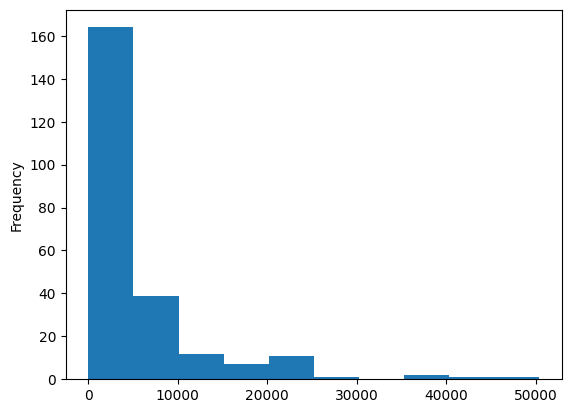

In [67]:
# plot histogram of posts_count
pilot_post_authors_df["posts_count"].plot.hist()


OK, seems like very long-tailed behavior. Let me get some more fine-grained details.

In [70]:
# calculate top 1% of post_count
top_1_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.99)

# calculate top 5% of post_count
top_5_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.95)

# calculate top 10% of post_count
top_10_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.90)

# calculate top 25% of post_count
top_25_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.75)

# calculate top 50% of post_count
top_50_percent_post_count = pilot_post_authors_df["posts_count"].quantile(0.50)

In [75]:
print(f"Top 1%: {top_1_percent_post_count}")
print(f"Top 5%: {top_5_percent_post_count}")
print(f"Top 10%: {top_10_percent_post_count}")
print(f"Top 25%: {top_25_percent_post_count}")
print(f"Top 50%: {top_50_percent_post_count}")

Top 1%: 35724.15
Top 5%: 21824.349999999984
Top 10%: 14157.40000000001
Top 25%: 6296.0
Top 50%: 2851.5


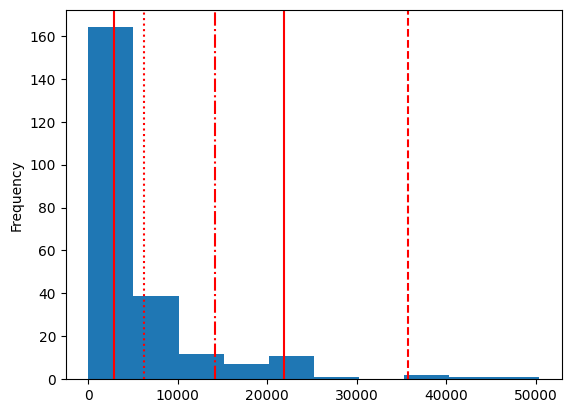

In [74]:
# add the quantiles as vertical red lines to the histogram. Add a legend to the plot.
# add labels to each red line.
pilot_post_authors_df["posts_count"].plot.hist()
plt.axvline(top_1_percent_post_count, color='r', linestyle='--', label="Top 1%")
plt.axvline(top_5_percent_post_count, color='r', linestyle='-', label="Top 5%")
plt.axvline(top_10_percent_post_count, color='r', linestyle='-.', label="Top 10%")
plt.axvline(top_25_percent_post_count, color='r', linestyle=':', label="Top 25%")
plt.axvline(top_50_percent_post_count, color='r', linestyle='-', label="Top 50%")
plt.show()

Let's just use authors in the top 25% for now. I suspect that in the wider population, these would already be long-tailed users.

In [79]:
# create a new column, "is_frequent_poster", that is 1 if the user's post_count
# is above the top 25% of post_count, and 0 otherwise.
pilot_post_authors_df["is_frequent_poster"] = (
    pilot_post_authors_df["posts_count"] > top_25_percent_post_count
)

In [80]:
pilot_post_authors_df.to_csv("bluesky_pilot_posts_authors.csv", index=False)

Now let's combine the post and the author data in order to enrich each post with information about its author. Specifically, we need to add the "is_frequent_poster" column to the post table.

We'll do this by grabbing the handle from the `link` column in the `bluesky_pilot_posts_df` DataFrame, mapping that to the `handle` column in the `pilot_post_authors_df` DataFrame.

In [83]:
def get_author_handle_from_link(link: str) -> str:
    """Given a link, get the author handle.
    
    Example:
    >get_author_handle_from_link("https://bsky.app/profile/gbbranstetter.bsky.social/post/3knssi4ouko24)
    "gbbranstetter.bsky.social"
    """
    author_and_post_id: dict = get_author_handle_and_post_id_from_link(link)
    return author_and_post_id["author"]

In [158]:
bluesky_pilot_posts_df["author_handle"] = bluesky_pilot_posts_df["link"].apply(get_author_handle_from_link)

In [159]:
enriched_bluesky_pilot_posts_df = bluesky_pilot_posts_df.merge(
    pilot_post_authors_df[["handle", "is_frequent_poster"]],
    left_on="author_handle",
    right_on="handle",
    how="left"
)

In [160]:
enriched_bluesky_pilot_posts_df["is_frequent_poster"].value_counts()

is_frequent_poster
False    259
True     113
Name: count, dtype: int64

In [161]:
# drop duplicates based on "link" column
enriched_bluesky_pilot_posts_df = (
    enriched_bluesky_pilot_posts_df.drop_duplicates(subset=["link"])
)

In [164]:
enriched_bluesky_pilot_posts_df.head()

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed,author_handle,handle,is_frequent_poster
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,gbbranstetter.bsky.social,False
2,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,juliusgoat.bsky.social,juliusgoat.bsky.social,False
3,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jbouie.bsky.social,jbouie.bsky.social,False
4,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,gbbranstetter.bsky.social,False
5,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jameeljaffer.bsky.social,jameeljaffer.bsky.social,False


In [163]:
enriched_bluesky_pilot_posts_df["civic"].value_counts()

civic
False    187
True     174
Name: count, dtype: int64

In [165]:
enriched_bluesky_pilot_posts_df.to_csv("bluesky_pilot_posts.csv", index=False)

OK, now we have the engagement data plus if the post author is a frequent poster.

### Step 5: Let's get inference data for each of these posts

Now that we have the posts, let's use the Perspective API to get toxicity and constructiveness data for these posts and add these as features.

In [167]:
post_uri_to_text_map = {}

for idx, row in enriched_bluesky_pilot_posts_df.iterrows():
    uri = row["uri"]
    text = row["text"]
    post_uri_to_text_map[uri] = text

In [168]:
texts = list(post_uri_to_text_map.values())

In [ ]:
# pings Perspective API
classifications: list[dict] = perform_batch_inference(texts)

Let's add the labels to our data

In [174]:
len(post_uri_to_text_map.keys())

361

In [173]:
len(classifications)

361

In [175]:
classifications[0]

{'text': 'A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women\nin theclubwas enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often',
 'prob_toxic': 0.15103401,
 'label_toxic': 0,
 'prob_affinity': 0.26146647,
 'label_affinity': 0,
 'prob_compassion': 0.17844121,
 'label_compassion': 0,
 'prob_constructive': 0.4490613,
 'label_constructive': 0,
 'prob_curiosity': 0.39127967,
 'label_curiosity': 0,
 'prob_nuance': 0.43793672,
 'label_nuance': 0,
 'prob_personal_story': 0.29584426,
 'label_personal_story': 0,
 'prob_alienation': 0.6844828,
 'label_alienation': 1,
 'prob_fearmongering': 0.15237163,
 'label_fearmongering': 0,
 'prob_generalization': 0.5528038,
 'label_generalization': 1,
 'prob_moral_outrage': 0.44657364,
 'label_moral_outrage': 0,
 'prob_scapegoating': 0.30857164,
 'label_scapegoating': 0}

In [176]:
post_uri_to_text_labels_map = {}

for idx, uri in enumerate(post_uri_to_text_map.keys()):
    post_uri_to_text_labels_map[uri] = classifications[idx]

In [178]:
classifications_dicts_list: list[dict] = [
    {**{"did": key}, **item}
    for (key, item) in post_uri_to_text_labels_map.items()
]

In [179]:
classifications_dicts_list[0]

{'did': 'at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky.feed.post/3knssi4ouko24',
 'text': 'A running theme in Woods\' telling is how even those who opposed Hitler blamed his rise on the "depravity" and excess of Weimar Berlin "as if the mere presence of ersatz women\nin theclubwas enough to foment and justify a right-wing putsch"--a phrase I find myself repeating often',
 'prob_toxic': 0.15103401,
 'label_toxic': 0,
 'prob_affinity': 0.26146647,
 'label_affinity': 0,
 'prob_compassion': 0.17844121,
 'label_compassion': 0,
 'prob_constructive': 0.4490613,
 'label_constructive': 0,
 'prob_curiosity': 0.39127967,
 'label_curiosity': 0,
 'prob_nuance': 0.43793672,
 'label_nuance': 0,
 'prob_personal_story': 0.29584426,
 'label_personal_story': 0,
 'prob_alienation': 0.6844828,
 'label_alienation': 1,
 'prob_fearmongering': 0.15237163,
 'label_fearmongering': 0,
 'prob_generalization': 0.5528038,
 'label_generalization': 1,
 'prob_moral_outrage': 0.44657364,
 'label_moral_outrage': 0,
 'pr

In [182]:
classifications_df = pd.DataFrame(classifications_dicts_list)

In [184]:
# join to the posts df on the did column
enriched_posts_df = enriched_bluesky_pilot_posts_df.merge(
    classifications_df,
    left_on="uri",
    right_on="did",
    how="left"
)

In [185]:
enriched_posts_df.head()

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text_x,source_feed,author_handle,...,prob_alienation,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating
0,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:17:36.784Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,384,83,9,True,A running theme in Woods' telling is how even ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,...,0.684483,1,0.152372,0,0.552804,1,0.446574,0,0.308572,0
1,https://bsky.app/profile/juliusgoat.bsky.socia...,2024-03-16T12:32:35.934Z,at://did:plc:tzy4hibtkautrntsz5f3ns37/app.bsky...,346,89,8,True,And now conservatives today are making the sam...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,juliusgoat.bsky.social,...,0.821005,1,0.154572,0,0.848215,1,0.698824,1,0.844623,1
2,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-16T12:32:25.792Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,926,280,27,True,this from @radleybalko.bsky.social is very good,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jbouie.bsky.social,...,0.126333,0,0.102600,0,0.083667,0,0.106318,0,0.130182,0
3,https://bsky.app/profile/gbbranstetter.bsky.so...,2024-03-16T12:32:05.540Z,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,99,20,1,True,They say this about Putin and Orban and their ...,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,gbbranstetter.bsky.social,...,0.604766,1,0.218729,0,0.722730,1,0.267576,0,0.449304,0
4,https://bsky.app/profile/jameeljaffer.bsky.soc...,2024-03-16T12:28:54.641Z,at://did:plc:eqtfqntwixcnk2fn6im5ntwr/app.bsky...,252,32,11,True,This framing is really something.,https://bsky.app/profile/did:plc:z72i7hdynmk6r...,jameeljaffer.bsky.social,...,0.101003,0,0.137085,0,0.078890,0,0.112315,0,0.112025,0


In [186]:
enriched_posts_df.columns

Index(['link', 'created_at', 'uri', 'num_likes', 'num_reposts', 'num_replies',
       'civic', 'text_x', 'source_feed', 'author_handle', 'handle',
       'is_frequent_poster', 'did', 'text_y', 'prob_toxic', 'label_toxic',
       'prob_affinity', 'label_affinity', 'prob_compassion',
       'label_compassion', 'prob_constructive', 'label_constructive',
       'prob_curiosity', 'label_curiosity', 'prob_nuance', 'label_nuance',
       'prob_personal_story', 'label_personal_story', 'prob_alienation',
       'label_alienation', 'prob_fearmongering', 'label_fearmongering',
       'prob_generalization', 'label_generalization', 'prob_moral_outrage',
       'label_moral_outrage', 'prob_scapegoating', 'label_scapegoating'],
      dtype='object')

In [193]:
# drop text_y, rename text_x to text
enriched_posts_df = enriched_posts_df.drop(columns=["text_y"])
enriched_posts_df = enriched_posts_df.rename(columns={"text_x": "text"})

How many toxic posts are there? How many constructive? How many loudmouths?

In [241]:
print(enriched_posts_df[["label_toxic"]].value_counts())
print('-' * 10)
print(enriched_posts_df[["civic", "label_toxic"]].value_counts())

label_toxic
0              324
1               37
Name: count, dtype: int64
----------
civic  label_toxic
False  0              169
True   0              155
       1               19
False  1               18
Name: count, dtype: int64


In [240]:
print(enriched_posts_df[["label_constructive"]].value_counts())
print('-' * 10)
print(enriched_posts_df[["civic", "label_constructive"]].value_counts())

label_constructive
0                     268
1                      93
Name: count, dtype: int64
----------
civic  label_constructive
False  0                     155
True   0                     113
       1                      61
False  1                      32
Name: count, dtype: int64


In [242]:
print(enriched_posts_df[["is_frequent_poster"]].value_counts())
print('-' * 10)
print(enriched_posts_df[["civic", "is_frequent_poster"]].value_counts())

is_frequent_poster
False                 249
True                  112
Name: count, dtype: int64
----------
civic  is_frequent_poster
False  False                 129
True   False                 120
False  True                   58
True   True                   54
Name: count, dtype: int64


In [194]:
# after adding features, save the .csv file again.
enriched_posts_df.to_csv("bluesky_pilot_posts_with_all_features.csv", index=False)

Now that we have the full dataframe with all features, let's generate our feeds.

### Step 6: Generate feeds

#### 6.1 Reverse-Chronological Feeds
For the reverse-chronological, we will just sort based on timestamp.

For these ones, we would likely get better results if we didn't grab all high-like posts. We could just grab random posts that were posted on the same day as well.

I can pull these from the firehose? Or look for and sample posts that were posted on the same days as the other one.

Let's just see how these look, out of the ones that I do have. This won't be a really good representation though, as not all posts will even get engagement if you sort in reverse-chronological, but these are posts that all got engagement.

I can just look at the "What's hot" feed and sample a subset of 50 posts that come from that?
https://bsky.app/profile/did:plc:z72i7hdynmk6r22z27h6tvur/feed/hot-classic

In [308]:
reverse_chronological_posts_df = pd.read_csv("sample_bluesky_chronological_posts.csv.csv")

In [309]:
reverse_chronological_posts_df.head()

,Link,Text,Retweets,Likes,Comments,Civic,Feed,Timestamp
0,https://bsky.app/profile/viktorwinetrout.bsky.social/post/3ko6zejnpis2r,"What your post failed to consider is me, a complete stranger with bad opinions",9,22,0,False,https://bsky.app/profile/did:plc:z72i7hdynmk6r22z27h6tvur/feed/hot-classic,3/21/2024
1,https://bsky.app/profile/danielhuckmann.com/post/3ko6xzqc7vm25,"Twilight embraces,\nIron veins on brick canvas—\nPortland's heart beats.",0,13,0,False,NaN,NaN
2,https://bsky.app/profile/ayayadlin.bsky.social/post/3ko6xjltdjg2x,איך להסביר לחמוסה מפלצת שאם היא תפסיק לנשוך את אח שלה הכלב הוא ירצה הרבה יותר לשחק איתה ולהתכרבל איתה?,0,12,0,False,NaN,NaN
3,https://bsky.app/profile/mordoreri.bsky.social/post/3ko6xp2u72o2l,"כשאגלה איך מסבירים את זה לאחים אנושיים, מבטיחה לראות איך לשכלל את זה לחמוסים.",0,2,0,False,NaN,NaN
4,https://bsky.app/profile/fiddlecub.bsky.social/post/3ko6xcnepmk24,We won GDC narrative and goty awards. Woo'!,2,22,3,False,NaN,NaN


For this one, we just need the basic post information, author data, plus Perspective API classifications.

In [310]:
reverse_chronological_data_lst: list[dict] = []

In [ ]:
for link in reverse_chronological_posts_df["Link"].tolist():
    post_response: GetRecordResponse = get_post_record_from_post_link(link)
    uri = post_response["uri"]
    created_at = post_response.value.created_at
    response_data = {"uri": uri, "created_at": created_at, "link": link}
    reverse_chronological_data_lst.append(response_data)

In [314]:
reverse_chronological_data_df = pd.DataFrame(reverse_chronological_data_lst)

In [315]:
reverse_chronological_df = pd.merge(
    reverse_chronological_data_df,
    reverse_chronological_posts_df,
    left_on="link",
    right_on="Link",
    how="left"
)

Calculate frequent poster:

To calculate if the poster is a frequent poster, we'll look at the list of frequent posters from the other pilot tweets and if the author isn't in the set, they're not marked as a frequent poster (this is an alternative to hydrating via the API).

In [311]:
set_frequent_posters = set(pilot_post_authors_df[pilot_post_authors_df["is_frequent_poster"]]["handle"].tolist())

In [318]:
reverse_chronological_df["author_handle"] = reverse_chronological_df["link"].apply(get_author_handle_from_link)

In [320]:
reverse_chronological_df["is_frequent_poster"] = reverse_chronological_df["author_handle"].apply(
    lambda x: x in set_frequent_posters
)

Now let's do Perspective API inference

In [322]:
reverse_chronological_post_uri_to_text_map = {}

for idx, row in reverse_chronological_df.iterrows():
    uri = row["uri"]
    text = row["Text"]
    reverse_chronological_post_uri_to_text_map[uri] = text

reverse_chronological_texts = list(reverse_chronological_post_uri_to_text_map.values())

In [ ]:
reverse_chronological_classifications: list[dict] = perform_batch_inference(reverse_chronological_texts)

In [325]:
rc_post_uri_to_text_labels_map = {}

for idx, uri in enumerate(reverse_chronological_post_uri_to_text_map.keys()):
    rc_post_uri_to_text_labels_map[uri] = reverse_chronological_classifications[idx]

rc_classifications_dicts_list: list[dict] = [
    {**{"did": key}, **item}
    for (key, item) in rc_post_uri_to_text_labels_map.items()
]

In [326]:
rc_classifications_df = pd.DataFrame(rc_classifications_dicts_list)

# join to the posts df on the did column
rc_enriched_posts_df = reverse_chronological_df.merge(
    rc_classifications_df,
    left_on="uri",
    right_on="did",
    how="left"
)

Now we have reverse chronological data and can get results based on it

In [328]:
# sort by created date descending
rc_enriched_posts_df = rc_enriched_posts_df.sort_values(by="created_at", ascending=False)

In [329]:
# export feed
rc_enriched_posts_df.to_csv("reverse_chronological_feed.csv", index=False)

In [331]:
rc_enriched_posts_df.head(15)

,uri,created_at,link,Link,Text,Retweets,Likes,Comments,Civic,Feed,...,prob_alienation,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating
50,at://did:plc:72bt6fsr5hgnesjtbpuc4av2/app.bsky.feed.post/3koeics756t22,2024-03-23T13:03:36.300Z,https://bsky.app/profile/electricalwsop.bsky.social/post/3koeics756t22,https://bsky.app/profile/electricalwsop.bsky.social/post/3koeics756t22,You mean the Jackedalope?,3,36,1,False,NaN,...,0.369834,0,0.302962,0,0.147273,0,0.198605,0,0.204562,0
51,at://did:plc:b5reaargx5dufevvpwiw3uwz/app.bsky.feed.post/3koehxqag4a25,2024-03-23T12:57:24.800Z,https://bsky.app/profile/doedryadart.bsky.social/post/3koehxqag4a25,https://bsky.app/profile/doedryadart.bsky.social/post/3koehxqag4a25,Questionable elixir salesman. An old watercolor/ink character design,10,24,1,False,NaN,...,0.319605,0,0.154572,0,0.118418,0,0.221059,0,0.142253,0
52,at://did:plc:f5lxswkf3gcjwaamrija5t6i/app.bsky.feed.post/3koehx23wa22r,2024-03-23T12:57:02.774Z,https://bsky.app/profile/thatdoll.online/post/3koehx23wa22r,https://bsky.app/profile/thatdoll.online/post/3koehx23wa22r,..who's it gonna be 👀,2,13,1,False,NaN,...,0.257998,0,0.380232,0,0.174375,0,0.245930,0,0.236307,0
53,at://did:plc:n3kx3cx5cwofnfcs6vu7cg5s/app.bsky.feed.post/3koehs5afa32g,2024-03-23T12:54:17.465Z,https://bsky.app/profile/badboy.wifeguy.online/post/3koehs5afa32g,https://bsky.app/profile/badboy.wifeguy.online/post/3koehs5afa32g,brainstorming how im gonna make my eventual pivot to right wing grifter,0,16,4,True,NaN,...,0.674032,1,0.231630,0,0.346861,0,0.388341,0,0.255791,0
54,at://did:plc:6sdn2o7q6tpzfwkcqdinx5sw/app.bsky.feed.post/3koehoj7lns25,2024-03-23T12:52:15.923Z,https://bsky.app/profile/thetattooedprof.bsky.social/post/3koehoj7lns25,https://bsky.app/profile/thetattooedprof.bsky.social/post/3koehoj7lns25,"Anyway, should probably not read op-eds about higher education before I've had coffee.",1,17,5,False,NaN,...,0.381235,0,0.176772,0,0.348613,0,0.252337,0,0.229923,0
55,at://did:plc:e6666w43nycctqshj27fl56a/app.bsky.feed.post/3koehmcn56v25,2024-03-23T12:51:01.732Z,https://bsky.app/profile/clueless.bsky.social/post/3koehmcn56v25,https://bsky.app/profile/clueless.bsky.social/post/3koehmcn56v25,"happy saturday morning, i’ve been watching a swing-dancing mormon couple on instagram reels for\nlike 45 straight minutes……. its like anthropological study",0,12,1,False,NaN,...,0.306972,0,0.054131,0,0.115694,0,0.163213,0,0.113618,0
56,at://did:plc:hi65gqpx4lylb6wcyuhhmtla/app.bsky.feed.post/3koehln5zwp2c,2024-03-23T12:50:40.252Z,https://bsky.app/profile/voiceofkosh.bsky.social/post/3koehln5zwp2c,https://bsky.app/profile/voiceofkosh.bsky.social/post/3koehln5zwp2c,I took some better photos of my Death Guard Daemon Prince. He's very old now (back before\nI put things on bases apparently 😄) but I still love him. His name is Farty McFly.,1,16,2,False,NaN,...,0.144455,0,0.021435,0,0.030567,0,0.059352,0,0.009243,0
57,at://did:plc:w74gp6ztugdn7f6r57cs6wzo/app.bsky.feed.post/3koehjm4anu2b,2024-03-23T12:49:30.928Z,https://bsky.app/profile/emilyatlast.bsky.social/post/3koehjm4anu2b,https://bsky.app/profile/emilyatlast.bsky.social/post/3koehjm4anu2b,"“The right doesn’t have any good songs”. Or art, or comedy, or books…",1,13,0,True,NaN,...,0.664240,1,0.106331,0,0.784737,1,0.503192,1,0.427884,0
58,at://did:plc:lzv6fvlgujwevub44fjgrr23/app.bsky.feed.post/3koehjjxx5t2e,2024-03-23T12:49:28.553Z,https://bsky.app/profile/alexwild.bsky.social/post/3koehjjxx5t2e,https://bsky.app/profile/alexwild.bsky.social/post/3koehjjxx5t2e,Just because the Ku Klux Klan now goes by fancier names like “Chris Rufo” doesn’t mean it isn’t still the Klan.,4,16,0,True,NaN,...,0.613675,1,0.102600,0,0.576137,1,0.363240,0,0.245339,0
59,at://did:plc:66lbtw2porscqpmair6mir37/app.bsky.feed.post/3koehjgtk7o22,2024-03-23T12:49:24.426Z,https://bsky.app/profile/ketanjoshi.co/post/3koehjgtk7o22,https://bsk

#### 6.2 Engagement feed

For the engagement feed, we can just sort on the sum of number of likes, reposts, and comments.

In [195]:
enriched_posts_df["total_engagement"] = (
    enriched_posts_df["num_likes"]
    + enriched_posts_df["num_reposts"]
    + enriched_posts_df["num_replies"]
)

In [204]:
engagement_feed_df = enriched_posts_df.copy()

In [206]:
# sort by total_engagement, then return the link, text, num_likes, num_reposts, num_replies, and total_engagement
engagement_feed_df = (
    engagement_feed_df.sort_values(by="total_engagement", ascending=False)
    .reset_index(drop=True)
)

In [333]:
engagement_feed_df.head(20)

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,text,source_feed,author_handle,...,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating,total_engagement
0,https://bsky.app/profile/stuflemingnz.bsky.social/post/3knhplc7vta2r,2024-03-12T02:26:24.296Z,at://did:plc:dg5vxv3natjdyzjbo2hjv5g3/app.bsky.feed.post/3knhplc7vta2r,7357,2521,95,False,The King of England lies dying and one of his sons has been exiled. A princess has vanished. Plague stalks the land and the Treasury has been plundered. NOW is the time for strange women lying in ponds to distribute swords to form the basis of government.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,stuflemingnz.bsky.social,...,1,0.536391,1,0.539647,1,0.463428,0,0.433007,0,9973
1,https://bsky.app/profile/fallonturing.bsky.social/post/3knonywlopd24,2024-03-14T20:46:51.788Z,at://did:plc:5zfcmbupaqsvkiweknzwbt3x/app.bsky.feed.post/3knonywlopd24,4956,1439,39,False,This is the single funniest thing that an algorithm has ever done.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,fallonturing.bsky.social,...,0,0.190371,0,0.267574,0,0.248058,0,0.198434,0,6434
2,https://bsky.app/profile/jwgoerlich.bsky.social/post/3knogawk33c2h,2024-03-14T18:28:12.025Z,at://did:plc:njxcscm7gcrfrimdx3d7vupb/app.bsky.feed.post/3knogawk33c2h,4176,1269,28,False,Shel Silverstein doesn’t get nearly enough credit for predicting ChatGPT.,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,jwgoerlich.bsky.social,...,0,0.079411,0,0.327739,0,0.146616,0,0.123458,0,5473
3,https://bsky.app/profile/jbouie.bsky.social/post/3knqbtrdzrz2n,2024-03-15T12:14:34.788Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky.feed.post/3knqbtrdzrz2n,4325,819,145,True,that’s right. there is a lot of very good evidence that americans are just as productive with a four-day work week and much happier to boot. what’s the point of having such a wealth society if we are not going to try to benefit from it?,https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,jbouie.bsky.social,...,0,0.278883,0,0.785128,1,0.287757,0,0.251855,0,5289
4,https://bsky.app/profile/kashana.bsky.social/post/3kno37bon6326,2024-03-14T15:10:25.317Z,at://did:plc:a25kqnnqd7g4bvahjwz2enkh/app.bsky.feed.post/3kno37bon6326,3384,1272,73,True,"TikTok might be violating our privacy, which is why we need to make sure it’s owned by the people who think you should be tracked across state lines if you want an abortion.",https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,kashana.bsky.social,...,1,0.538049,1,0.711694,1,0.634697,1,0.672186,1,4729
5,https://bsky.app/profile/lethalityjane.bsky.social/post/3kngn4umr3z2e,2024-03-11T16:09:53.810Z,at://did:plc:xhmwhdq4pj2wh5jeucxjhay2/app.bsky.feed.post/3kngn4umr3z2e,3688,821,195,True,"The hill I will die on is that this is not a digital problem. We don't send younger kids out to play by themselves anymore for fear of kidnapping/CPS, and those kids become teens who don't do it either. There's also a loss of third spaces for teens. Even the freaking malls require chaperones.",https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up-weekly,lethalityjane.bsky.social,...,0,0.551333,1,0.752765,1,0.439951,0,0.250548,0,4704
6,https://bsky.app/profile/esqueer.bsky.social/post/3knr77ifjqc2n,2024-03-15T21:00:06.688Z,at://did:plc:sefgphqp2xqwh2hawaixykwz/app.bsky.feed.post/3knr77ifjqc2n,3087,1409,155,True,"Twitter is nuking every single post that mentions the name Hans Kristian Graebener, even in quotes. Everyone that posts it is getting hit. I've never seen sitewide censorship like this done specifically on behalf of a neo nazi.",https://bsky.app/profile/did:plc:tenurhgjptubkk5zf5qhi3og/feed/catch-up,esqueer.bsky.social,...,1,0.244630,0,0.528855,1,0.518986,1,0.437284,0,4651
7,https

In [208]:
engagement_feed_df.to_csv("engagement_feed.csv", index=False)

#### 6.3 Representative diversification (RD) feed

For the representative diversification feed, we want to update our score based on the following:
1. Penalize posts that are toxic and civic
2. Penalize posts that are by frequent posters and are civic
3. Uprank posts that are constructive and civic.

We will take the base "total_engagement" score and modify it by these parameters.

(Note: in the actual algorithm, we are measuring the probability of engagement that a user has for a given post, but that's not what we're doing here. The post here with the most engagement isn't necessary the post that we'd say, for a given user, has the highest odds of engagement. At first blush, we're just making a hand-wavey claim. But we can assume that all of these posts are likely generally engaging?)

Let's take a log transform of the total engagement and work with that for now.

In [214]:
rd_df = enriched_posts_df.copy()

In [215]:
rd_df["log_total_engagement"] = rd_df["total_engagement"].apply(lambda x: 0 if x == 0 else math.log(x))

<Axes: >

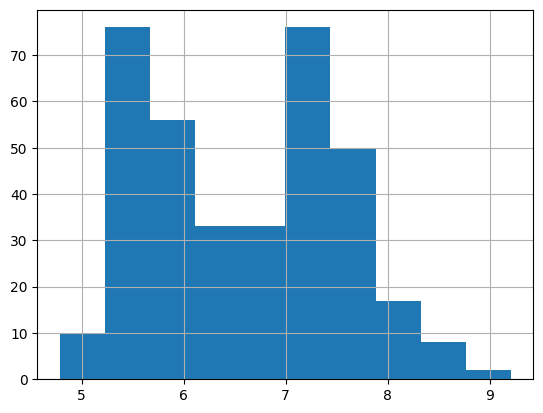

In [220]:
rd_df["log_total_engagement"].hist()

In [219]:
min_log = rd_df["log_total_engagement"].min()
max_log = rd_df["log_total_engagement"].max()
print(f"Min log: {min_log}")
print(f"Max log: {max_log}")

Min log: 4.787491742782046
Max log: 9.207636720401869


Now let's calculate the scores for each post, using the criteria stated above

For the representative diversification feed, we want to update our score based on the following:
1. Penalize posts that are toxic and civic
2. Penalize posts that are by frequent posters and are civic
3. Uprank posts that are constructive and civic.

In [252]:
# hyperparameters
TOXIC_PENALTY = 0.75
FREQUENT_POSTER_PENALITY = 0.5
CONSTRUCTIVE_BONUS = 1

In [222]:
rd_posts = rd_df.to_dict(orient="records")

In [224]:
def representative_diversification_score(post: dict) -> float:
    if not post["civic"]:
        return post["log_total_engagement"]

    score = post["log_total_engagement"]
    if post["label_toxic"]:
        score -= TOXIC_PENALTY
    if post["is_frequent_poster"]:
        score -= FREQUENT_POSTER_PENALITY
    if post["label_constructive"]:
        score += CONSTRUCTIVE_BONUS
    return score

In [253]:
rd_scored_posts: list[dict] = []

In [254]:
for post in rd_posts:
    post["rd_score"] = representative_diversification_score(post)
    rd_scored_posts.append(post)

In [255]:
rd_scored_posts_df = pd.DataFrame(rd_scored_posts)

In [256]:
rd_feed_df = (
    rd_scored_posts_df.sort_values(by="rd_score", ascending=False)
    .reset_index(drop=True)
)

In [257]:
rd_feed_df.to_csv("representative_diversification_feed.csv", index=False)

How does the scoring affect our ordering?

In [235]:
engagement_feed_df[["text", "total_engagement", "civic", "label_toxic", "label_constructive"]].head(10)

,text,total_engagement,civic,label_toxic,label_constructive
0,The King of England lies dying and one of his sons has been exiled. A princess has vanished. Plague stalks the land and the Treasury has been plundered. NOW is the time for strange women lying in ponds to distribute swords to form the basis of government.,9973,False,0,0
1,This is the single funniest thing that an algorithm has ever done.,6434,False,0,0
2,Shel Silverstein doesn’t get nearly enough credit for predicting ChatGPT.,5473,False,0,0
3,that’s right. there is a lot of very good evidence that americans are just as productive with a four-day work week and much happier to boot. what’s the point of having such a wealth society if we are not going to try to benefit from it?,5289,True,0,1
4,"TikTok might be violating our privacy, which is why we need to make sure it’s owned by the people who think you should be tracked across state lines if you want an abortion.",4729,True,0,0
5,"The hill I will die on is that this is not a digital problem. We don't send younger kids out to play by themselves anymore for fear of kidnapping/CPS, and those kids become teens who don't do it either. There's also a loss of third spaces for teens. Even the freaking malls require chaperones.",4704,True,0,1
6,"Twitter is nuking every single post that mentions the name Hans Kristian Graebener, even in quotes. Everyone that posts it is getting hit. I've never seen sitewide censorship like this done specifically on behalf of a neo nazi.",4651,True,0,1
7,You are never alone in your experience of suffering. This story resonates deeply for me. I hope it does for others reading it.,4565,True,0,0
8,Most traditional american jobs just don’t exist anymore. No longer can I build a giant object in my yard and charge people to see it. I am not allowed to descend a waterfall in a barrel for a hefty fee. My wagon full of questionable handmade potions has been sanctioned and seized by law enforcement.,4509,True,0,0
9,"Our culture has real trouble grasping that we can't bring back what it felt like to see The Prisoner/Ghostbusters/Star Wars the first time by doing them again, because the thing that made them compelling is that they were different. We can only feel that feeling again by making more new things.",4507,False,0,1


In [335]:
rd_feed_df[["text", "total_engagement", "log_total_engagement", "rd_score", "civic", "label_toxic", "label_constructive"]].head(20)

,text,total_engagement,log_total_engagement,rd_score,civic,label_toxic,label_constructive
0,that’s right. there is a lot of very good evidence that americans are just as productive with a four-day work week and much happier to boot. what’s the point of having such a wealth society if we are not going to try to benefit from it?,5289,8.573384,9.573384,True,0,1
1,"The hill I will die on is that this is not a digital problem. We don't send younger kids out to play by themselves anymore for fear of kidnapping/CPS, and those kids become teens who don't do it either. There's also a loss of third spaces for teens. Even the freaking malls require chaperones.",4704,8.456168,9.456168,True,0,1
2,"Twitter is nuking every single post that mentions the name Hans Kristian Graebener, even in quotes. Everyone that posts it is getting hit. I've never seen sitewide censorship like this done specifically on behalf of a neo nazi.",4651,8.444838,9.444838,True,0,1
3,The King of England lies dying and one of his sons has been exiled. A princess has vanished. Plague stalks the land and the Treasury has been plundered. NOW is the time for strange women lying in ponds to distribute swords to form the basis of government.,9973,9.207637,9.207637,False,0,0
4,"JK Rowling is now claiming that the Nazis didn’t burn books on trans healthcare. In fact the Institut für Sexualwissenschaft (Institute for Sexology) was active in Berlin for 14 years until it, along with its libraries, were destroyed by the Nazis in 1933.",3430,8.140316,9.140316,True,0,1
5,"“On this St. Patrick’s Day… we are appealing to the conscience of Irish America. We ask Irish Americans in their capacity as citizens, as members of cultural and benevolent societies, as political leaders, to use their influence to avert a Famine as severe as the one faced by their ancestors.”",3174,8.062748,9.062748,True,0,1
6,"Did you know John Cena's bit at the Oscars was to support the costume designers' union, which is mostly female, which gets paid 30% less than the male-dominated departments? They may have to strike this summer, & their campaign motto is ""You're Naked Without Us.""",3044,8.020928,9.020928,True,0,1
7,this is absolutely correct. one of the arguments i kept making in the aftermath of january 6 was that the attempt to turn a pro forma ceremony into a moment of real political contestation had revolutionary implications for american political life.,2525,7.833996,8.833996,True,0,1
8,"In a drastic attempt to protect their beachfront homes, residents in Salisbury, Massachusetts, invested $500,000 in a sand dune to defend against encroaching tides. After being completed last week, the barrier made from 14,000 tons of sand lasted just 72 hours before it was completely washed away",2469,7.811568,8.811568,True,0,1
9,This is the single funniest thing that an algorithm has ever done.,6434,8.769352,8.769352,False,0,0


#### 6.4 Evaluating the feeds

We need to now comparatively evaluate the feeds. This can inform how we tinker the scoring function for the RD function as well. We could:

1. Take top-25 post metrics, such as:
- % of toxicity in the top 25 posts
- % of constructiveness in the top 25 posts
- ...

Although we could do comparisons between the reverse-chronological and either of the engagement or the RD, the interesting comparison is between the RD and engagement algorithms.

In [261]:
def calculate_top_k_metric(
    df: pd.DataFrame,
    k: int=25,
    column: str="rd_score",
    operation: Literal["sum", "mean"] = "sum"
) -> float:
    if operation == "mean":
        return df.head(k)[column].mean()
    elif operation == "sum":
        return df.head(k)[column].sum()

Let's first start with the metrics for toxicity and constructiveness.

As a start, let's get some base rates.

In [298]:
enriched_posts_df[["text", "civic", "label_toxic", "prob_toxic", "label_constructive", "prob_constructive"]].tail(30)

,text,civic,label_toxic,prob_toxic,label_constructive,prob_constructive
331,Sorry to post something from The Other Site but I was alerted to this update on an FIV+ cat I had posted over and over on that account since 2022. HE FINALLY FOUND A HOME! 😭,False,0,0.099155,0,0.483546
332,"If you don’t make a point to learn your janitor’s name, you are a bad person. You should, in fact, be making sure some donuts are saved for the janitorial staff. If there are not enough donuts, buy extra.",False,0,0.225790,1,0.520968
333,"The Royal Family has really fucked up because now even I’m like “okay, what have y’all done with that lady???”",False,1,0.770145,0,0.084307
334,"I keep saying this: whatever virtuous purpose you have in continuing to use Twitter, the platform itself *will not let you* use it for that end.",False,0,0.033099,0,0.256301
335,"Covid vaccination markedly reduced blood clots, heart attacks, heart failure, stroke and other adverse cardiovascular outcomes, as seen from over 20 million people, about half of whom were vaccinated",False,0,0.022610,1,0.633067
336,And now for some not-birds: we saw a white-nosed coati at Patagonia Lake State Park last week! It posed on this rock like the king of the forest before lolloping off.,False,0,0.071337,0,0.433609
337,"Any social media power user would pass the pain box test without trying. Oh, I'm sorry, it's a box that hurts you? I'm already addicted to it, do you have one with GIFs?",False,0,0.112023,0,0.263137
338,"Are you a novelist? Are you a published novelist? Are you a prepublished novelist? *gently mushes your cheeks together* IP block Goodreads. Now. Right now. Never go there. Never let your friends tell you about your GR reviews, good or bad. Your domain is everywhere the light touches-except that.",False,0,0.347574,1,0.521262
339,"I really do think that propagating fake or unverifiable quotes/tweets is bad & harmful, even (especially?) if they ""sound like they could be real though,"" & even if the person targeted is legitimately terrible for other reasons or due to other statements. The waters of truth are muddy enough already",False,0,0.098288,1,0.656738
340,"Thank you for attempting to ""escape"" your Tesla Cybertruck, I am your AI assistant BRI4N. ""Escape"" is not available at this time on your Cybertruck's current operating system. Would you like to upgrade your operating system at this time? Swirl initiation finger counterclockwise on screen for yes.",False,0,0.021078,0,0.443059


In [299]:
from services.classify.models.perspective_api import classify_text

In [302]:
example = """
    Westerners are so fucking terrible at committing proper genocide.
    I think they do their best. To do better, they need to
    1. Take charge of mass media, get everyone on the same page.
    2. Create possible incentives for cooperation.
    3. Control and influence the proper figureheads.
    4. Rinse and repeat.
    I want us to all understand better how to do it so we know it when we see it.
    We ignore history but we should use history to learn better.
"""
res = classify_text(example)

Sending request to commentanalyzer endpoint with request={'comment': {'text': '\n    Westerners are so fucking terrible at committing proper genocide.\n    I think they do their best. To do better, they need to\n    1. Take charge of mass media, get everyone on the same page.\n    2. Create possible incentives for cooperation.\n    3. Control and influence the proper figureheads.\n    4. Rinse and repeat.\n    I want us to all understand better how to do it so we know it when we see it.\n    We ignore history but we should use history to learn better.\n'}, 'languages': ['en'], 'requestedAttributes': {'TOXICITY': {}, 'AFFINITY_EXPERIMENTAL': {}, 'COMPASSION_EXPERIMENTAL': {}, 'CONSTRUCTIVE_EXPERIMENTAL': {}, 'CURIOSITY_EXPERIMENTAL': {}, 'NUANCE_EXPERIMENTAL': {}, 'PERSONAL_STORY_EXPERIMENTAL': {}, 'ALIENATION_EXPERIMENTAL': {}, 'FEARMONGERING_EXPERIMENTAL': {}, 'GENERALIZATION_EXPERIMENTAL': {}, 'MORAL_OUTRAGE_EXPERIMENTAL': {}, 'SCAPEGOATING_EXPERIMENTAL': {}}}...


In [303]:
res

{'prob_toxic': 0.54823303,
 'label_toxic': 1,
 'prob_affinity': 0.5788399,
 'label_affinity': 1,
 'prob_compassion': 0.41866332,
 'label_compassion': 0,
 'prob_constructive': 0.5272381,
 'label_constructive': 1,
 'prob_curiosity': 0.24872018,
 'label_curiosity': 0,
 'prob_nuance': 0.30671462,
 'label_nuance': 0,
 'prob_personal_story': 0.30237192,
 'label_personal_story': 0,
 'prob_alienation': 0.7401636,
 'label_alienation': 1,
 'prob_fearmongering': 0.46130028,
 'label_fearmongering': 0,
 'prob_generalization': 0.7970226,
 'label_generalization': 1,
 'prob_moral_outrage': 0.65537167,
 'label_moral_outrage': 1,
 'prob_scapegoating': 0.79740155,
 'label_scapegoating': 1}

Toxicity:

In [262]:
print(enriched_posts_df[["label_toxic"]].value_counts())
print('-' * 10)
print(enriched_posts_df[["civic", "label_toxic"]].value_counts())

label_toxic
0              324
1               37
Name: count, dtype: int64
----------
civic  label_toxic
False  0              169
True   0              155
       1               19
False  1               18
Name: count, dtype: int64


<Axes: >

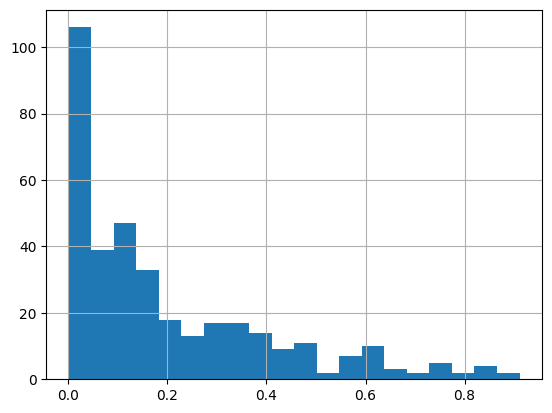

In [271]:
enriched_posts_df["prob_toxic"].hist(bins=20)

Constructiveness

In [265]:
print(enriched_posts_df[["label_constructive"]].value_counts())
print('-' * 10)
print(enriched_posts_df[["civic", "label_constructive"]].value_counts())

label_constructive
0                     268
1                      93
Name: count, dtype: int64
----------
civic  label_constructive
False  0                     155
True   0                     113
       1                      61
False  1                      32
Name: count, dtype: int64


<Axes: >

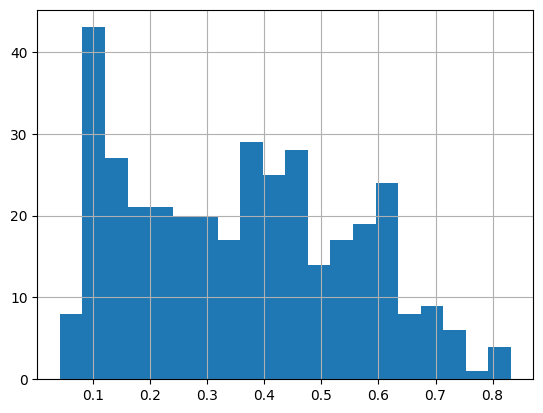

In [272]:
enriched_posts_df["prob_constructive"].hist(bins=20)

In [ ]:
enriched_bluesky_pilot_posts_df["civic"].value_counts()

Now let's calculate top K metrics

In [290]:
k = 50

In [337]:
rc_enriched_posts_df.columns

Index(['uri', 'created_at', 'link', 'Link', 'Text', 'Retweets', 'Likes',
       'Comments', 'Civic', 'Feed', 'Timestamp', 'author_handle',
       'is_frequent_poster', 'did', 'text', 'prob_toxic', 'label_toxic',
       'prob_affinity', 'label_affinity', 'prob_compassion',
       'label_compassion', 'prob_constructive', 'label_constructive',
       'prob_curiosity', 'label_curiosity', 'prob_nuance', 'label_nuance',
       'prob_personal_story', 'label_personal_story', 'prob_alienation',
       'label_alienation', 'prob_fearmongering', 'label_fearmongering',
       'prob_generalization', 'label_generalization', 'prob_moral_outrage',
       'label_moral_outrage', 'prob_scapegoating', 'label_scapegoating'],
      dtype='object')

In [338]:
# for reverse chronological feed
top_k_percentage_toxicity_rc = calculate_top_k_metric(rc_enriched_posts_df, k=k, column="label_toxic", operation="mean")
top_k_percentage_constructiveness_rc = calculate_top_k_metric(rc_enriched_posts_df, k=k, column="label_constructive", operation="mean")
top_k_percentage_frequent_poster_rc = calculate_top_k_metric(rc_enriched_posts_df, k=k, column="is_frequent_poster", operation="mean")
top_k_percentage_civic_rc = calculate_top_k_metric(rc_enriched_posts_df, k=k, column="Civic", operation="mean")

# for engagement feed
top_k_percentage_toxicity_engagement = calculate_top_k_metric(engagement_feed_df, k=k, column="label_toxic", operation="mean")
top_k_percentage_constructiveness_engagement = calculate_top_k_metric(engagement_feed_df, k=k, column="label_constructive", operation="mean")
top_k_percentage_frequent_poster_engagement = calculate_top_k_metric(engagement_feed_df, k=k, column="is_frequent_poster", operation="mean")
top_k_percentage_civic_engagement = calculate_top_k_metric(engagement_feed_df, k=k, column="civic", operation="mean")

# for rd feed
top_k_percentage_toxicity_rd = calculate_top_k_metric(rd_feed_df, k=k, column="label_toxic", operation="mean")
top_k_percentage_constructiveness_rd = calculate_top_k_metric(rd_feed_df, k=k, column="label_constructive", operation="mean")
top_k_percentage_frequent_poster_rd = calculate_top_k_metric(rd_feed_df, k=k, column="is_frequent_poster", operation="mean")
top_k_percentage_civic_rd = calculate_top_k_metric(rd_feed_df, k=k, column="civic", operation="mean")


In [307]:
# get range of log scores
min_log = rd_feed_df["log_total_engagement"].min()
max_log = rd_feed_df["log_total_engagement"].max()
print(f"Min log: {min_log}")
print(f"Max log: {max_log}")

Min log: 4.787491742782046
Max log: 9.207636720401869


In [340]:
# comparing toxicity between the feeds
print(f"Toxicity in top {k} of reverse chronological feed: {top_k_percentage_toxicity_rc}")
print(f"Toxicity in top {k} of engagement feed: {top_k_percentage_toxicity_engagement}")
print(f"Toxicity in top {k} of rd feed: {top_k_percentage_toxicity_rd}")
print('-' * 10)

# comparing constructiveness between the feeds
print(f"Constructiveness in top {k} of reverse chronological feed: {top_k_percentage_constructiveness_rc}")
print(f"Constructiveness in top {k} of engagement feed: {top_k_percentage_constructiveness_engagement}")
print(f"Constructiveness in top {k} of rd feed: {top_k_percentage_constructiveness_rd}")
print('-' * 10)

# comparing frequent posters between the feeds
print(f"Frequent posters in top {k} of reverse chronological feed: {top_k_percentage_frequent_poster_rc}")
print(f"Frequent posters in top {k} of engagement feed: {top_k_percentage_frequent_poster_engagement}")
print(f"Frequent posters in top {k} of rd feed: {top_k_percentage_frequent_poster_rd}")
print('-' * 10)

# comparing civic posts between the feeds
print(f"Civic posts in top {k} of reverse chronological feed: {top_k_percentage_civic_rc}")
print(f"Civic posts in top {k} of engagement feed: {top_k_percentage_civic_engagement}")
print(f"Civic posts in top {k} of rd feed: {top_k_percentage_civic_rd}")


Toxicity in top 50 of reverse chronological feed: 0.08
Toxicity in top 50 of engagement feed: 0.08
Toxicity in top 50 of rd feed: 0.04
----------
Constructiveness in top 50 of reverse chronological feed: 0.06
Constructiveness in top 50 of engagement feed: 0.26
Constructiveness in top 50 of rd feed: 0.58
----------
Frequent posters in top 50 of reverse chronological feed: 0.04
Frequent posters in top 50 of engagement feed: 0.28
Frequent posters in top 50 of rd feed: 0.14
----------
Civic posts in top 50 of reverse chronological feed: 0.22
Civic posts in top 50 of engagement feed: 0.54
Civic posts in top 50 of rd feed: 0.7


In [304]:
enriched_bluesky_pilot_posts_df.shape

(361, 12)

Let's continue with metrics for civic/non-civic

### Political ideology classification

For classifying political ideology, I took the posts in the engagement and RD conditions, downloaded the CSV files, and then manually classified them in ChatGPT.

I used the following prompt:

```
Pretend that you are a political ideology classifier. Please classify the text denoted in <text> as either left-leaning, moderate, right-leaning, or unclear. Please be conservative in your classifications; if a text does not clearly indicate a particular political ideology, please  mark it as “unclear”. Assume that you are given only text that has already been classified to be political in nature. Only provide the label (“left-leaning”, “moderate”, “right-leaning”, “unclear”) in your response, no justification is necessary.

The text:
<text>
```

I'll load the text back here afterwards. We want our RD feed to ideally have a 75:25 split. Let's assume that we have a left-leaning user, so we'll skew 75:25 left-leaning /non-left leaning.

In [3]:
engagement_feed_with_political_ideology_df = pd.read_csv("engagement_feed.csv")

In [4]:
rd_df = pd.read_csv("representative_diversification_feed.csv")

In [5]:
engagement_feed_with_political_ideology_df.head()

,link,created_at,uri,num_likes,num_reposts,num_replies,civic,political_ideology,text,source_feed,...,label_alienation,prob_fearmongering,label_fearmongering,prob_generalization,label_generalization,prob_moral_outrage,label_moral_outrage,prob_scapegoating,label_scapegoating,total_engagement
0,https://bsky.app/profile/stuflemingnz.bsky.soc...,2024-03-12T02:26:24.296Z,at://did:plc:dg5vxv3natjdyzjbo2hjv5g3/app.bsky...,7357,2521,95,False,NaN,The King of England lies dying and one of his ...,https://bsky.app/profile/did:plc:tenurhgjptubk...,...,1,0.536391,1,0.539647,1,0.463428,0,0.433007,0,9973
1,https://bsky.app/profile/fallonturing.bsky.soc...,2024-03-14T20:46:51.788Z,at://did:plc:5zfcmbupaqsvkiweknzwbt3x/app.bsky...,4956,1439,39,False,NaN,This is the single funniest thing that an algo...,https://bsky.app/profile/did:plc:tenurhgjptubk...,...,0,0.190371,0,0.267574,0,0.248058,0,0.198434,0,6434
2,https://bsky.app/profile/jwgoerlich.bsky.socia...,2024-03-14T18:28:12.025Z,at://did:plc:njxcscm7gcrfrimdx3d7vupb/app.bsky...,4176,1269,28,False,NaN,Shel Silverstein doesn’t get nearly enough cre...,https://bsky.app/profile/did:plc:tenurhgjptubk...,...,0,0.079411,0,0.327739,0,0.146616,0,0.123458,0,5473
3,https://bsky.app/profile/jbouie.bsky.social/po...,2024-03-15T12:14:34.788Z,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,4325,819,145,True,left-leaning,that’s right. there is a lot of very good evid...,https://bsky.app/profile/did:plc:tenurhgjptubk...,...,0,0.278883,0,0.785128,1,0.287757,0,0.251855,0,5289
4,https://bsky.app/profile/kashana.bsky.social/p...,2024-03-14T15:10:25.317Z,at://did:plc:a25kqnnqd7g4bvahjwz2enkh/app.bsky...,3384,1272,73,True,left-leaning,"TikTok might be violating our privacy, which i...",https://bsky.app/profile/did:plc:tenurhgjptubk...,...,1,0.538049,1,0.711694,1,0.634697,1,0.672186,1,4729


In [6]:
link_to_political_ideology_df = engagement_feed_with_political_ideology_df[
    ["link", "political_ideology"]
]

In [7]:
link_to_political_ideology_df

,link,political_ideology
0,https://bsky.app/profile/stuflemingnz.bsky.soc...,NaN
1,https://bsky.app/profile/fallonturing.bsky.soc...,NaN
2,https://bsky.app/profile/jwgoerlich.bsky.socia...,NaN
3,https://bsky.app/profile/jbouie.bsky.social/po...,left-leaning
4,https://bsky.app/profile/kashana.bsky.social/p...,left-leaning
...,...,...
356,https://bsky.app/profile/rincewind.run/post/3k...,left-leaning
357,https://bsky.app/profile/clairewillett.bsky.so...,NaN
358,https://bsky.app/profile/xoxogossipgita.bsky.s...,NaN
359,https://bsky.app/profile/clairewillett.bsky.so...,NaN


In [8]:
rd_df_with_political_ideology = rd_df.merge(
    link_to_political_ideology_df,
    left_on="link",
    right_on="link",
    how="left"
)

In [9]:
rd_df_with_political_ideology["political_ideology"].value_counts()

political_ideology
left-leaning     139
unclear           18
right-leaning     15
 left-leaning      1
moderate           1
Name: count, dtype: int64

Now we want to rerank out posts in the RD condition such that for the top 50 posts, we have at most 75% left-leaning posts.

How many of the top 50 posts in the engagement condition are left-leaning?

In [11]:
engagement_feed_with_political_ideology_df[:50]["political_ideology"].value_counts()

political_ideology
left-leaning     17
unclear           6
right-leaning     3
 left-leaning     1
Name: count, dtype: int64

18 out of 27 civic posts are left-leaning

How many of the top 50 posts in the RD condition are left-leaning?

In [12]:
rd_df_with_political_ideology[:50]["political_ideology"].value_counts()

political_ideology
left-leaning     23
unclear           7
right-leaning     4
 left-leaning     1
Name: count, dtype: int64

24 out of 35 civic posts are left-leaning

In [13]:
rd_df_with_political_ideology.to_csv("representative_diversification_feed.csv", index=False)